##### Импорт библиотек

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score 
import xgboost as xgb
from lightgbm import LGBMRegressor
import joblib

print("Библиотеки загружены!\n")

df = pd.read_csv('df/obr.csv', parse_dates=['datetime'], index_col='datetime')
print(f"Данные загружены: {df.shape}")

Библиотеки загружены!

Данные загружены: (260640, 11)


In [24]:
# СОЗДАНИЕ ПРИЗНАКОВ НА ОСНОВЕ EDA
print("Создание признаков на основе EDA...")
print(f"Размер данных: {df.shape}")

# Циклические признаки для часа (из суточной сезонности)
df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)

# Пиковые периоды (из анализа сезонности)
df['is_evening_peak'] = ((df['hour'] >= 18) & (df['hour'] <= 22)).astype(int)  # Вечерний пик
df['is_morning_peak'] = ((df['hour'] >= 7) & (df['hour'] <= 9)).astype(int)    # Утренний подъем
df['is_night'] = ((df['hour'] >= 0) & (df['hour'] <= 6)).astype(int)           # Ночной провал

# Особые дни (из недельной сезонности)
df['is_sunday'] = (df['day_of_week'] == 6).astype(int)  # Воскресенье - пиковый день
df['is_friday'] = (df['day_of_week'] == 4).astype(int)  # Пятница - минимальный день

# Лаги (из автокорреляции)
df['lag_1h'] = df['Global_active_power'].shift(1)    # На 1 час назад
df['lag_24h'] = df['Global_active_power'].shift(24)  # На 24 часа назад (сутки)

# Скользящие средние (из временного ряда)
df['rolling_mean_3h'] = df['Global_active_power'].rolling(window=3).mean()    # 3 часа
df['rolling_mean_24h'] = df['Global_active_power'].rolling(window=24).mean()  # Сутки

# Удаляем строки с NaN (появились из-за лагов и скользящих средних)
df = df.dropna()

print(f"Признаки созданы. Размер данных: {df.shape}")
print(f"Колонки: {list(df.columns)}")

Создание признаков на основе EDA...
Размер данных: (260640, 11)
Признаки созданы. Размер данных: (260616, 22)
Колонки: ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'hour', 'day_of_week', 'month', 'is_weekend', 'hour_sin', 'hour_cos', 'is_evening_peak', 'is_morning_peak', 'is_night', 'is_sunday', 'is_friday', 'lag_1h', 'lag_24h', 'rolling_mean_3h', 'rolling_mean_24h']


In [25]:
df.sample(5)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,day_of_week,month,...,hour_cos,is_evening_peak,is_morning_peak,is_night,is_sunday,is_friday,lag_1h,lag_24h,rolling_mean_3h,rolling_mean_24h
datetime,,,,,,,,,,,,,,,,,,,,,
2007-01-08 07:29:00,0.744,0.110,239.40,3.2,0.0,0.0,0.0,7,0,1,...,-0.258819,0,1,0,0,0,0.642,0.680,0.673333,0.665583
2007-03-19 04:30:00,0.224,0.000,243.68,1.0,0.0,0.0,0.0,4,0,3,...,0.500000,0,0,1,0,0,0.224,0.222,0.229333,0.291083
2007-02-02 20:50:00,0.490,0.000,241.76,2.0,0.0,0.0,0.0,20,4,2,...,0.500000,1,0,0,0,1,0.490,1.336,0.490000,1.084833
2007-03-23 13:07:00,0.218,0.000,241.79,0.8,0.0,0.0,0.0,13,4,3,...,-0.965926,0,0,0,0,1,0.218,0.332,0.218000,0.271833
2007-04-27 16:45:00,0.474,0.224,235.67,2.2,0.0,1.0,0.0,16,4,4,...,-0.500000,0,0,0,0,1,0.478,0.454,0.476667,0.435583


In [26]:
# ПОДГОТОВКА ДАННЫХ ДЛЯ ОБУЧЕНИЯ
print("Подготовка данных...")

# Целевая переменная
y = df['Global_active_power']

# Признаки (исключаем целевую и временную метку)
feature_columns = [col for col in df.columns if col not in ['Global_active_power', 'datetime']]
X = df[feature_columns]

print(f"Признаки: {len(feature_columns)}")
print(f"Целевая переменная: {y.name}")

# Разделение на train/test с учетом времени (ВАЖНО для временных рядов!)
# Берем первые 80% для обучения, последние 20% для тестирования
split_index = int(len(df) * 0.8)

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]

y_train = y.iloc[:split_index] 
y_test = y.iloc[split_index:]

print(f"\nРазделение данных:")
print(f"Обучающая выборка: {X_train.shape[0]} записей")
print(f"Тестовая выборка: {X_test.shape[0]} записей")
print(f"Дата начала train: {X_train.index.min()}")
print(f"Дата конца test: {X_test.index.max()}")

Подготовка данных...
Признаки: 21
Целевая переменная: Global_active_power

Разделение данных:
Обучающая выборка: 208492 записей
Тестовая выборка: 52124 записей
Дата начала train: 2007-01-01 00:24:00
Дата конца test: 2007-06-30 23:59:00


In [27]:
# ОБУЧЕНИЕ МОДЕЛЕЙ
print("Обучение моделей...")

# Словарь для хранения моделей и результатов
models = {}
results = {}

# A. RANDOM FOREST
print("\nОбучение RandomForest...")
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
models['RandomForest'] = rf_model

# B. XGBOOST
print("Обучение XGBoost...")
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)
models['XGBoost'] = xgb_model

# C. LIGHTGBM
print("Обучение LightGBM...")
lgb_model = LGBMRegressor(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
)
lgb_model.fit(X_train, y_train)
models['LightGBM'] = lgb_model

print("Все модели обучены!")

Обучение моделей...

Обучение RandomForest...
Обучение XGBoost...
Обучение LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005964 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1960
[LightGBM] [Info] Number of data points in the train set: 208492, number of used features: 21
[LightGBM] [Info] Start training from score 1.227624
Все модели обучены!



Оценка качества моделей на тестовой выборке:

RandomForest:
  MAE:  0.0144 кВт
  RMSE: 0.0293 кВт
  R²:   0.9991

XGBoost:
  MAE:  0.0141 кВт
  RMSE: 0.0261 кВт
  R²:   0.9993

LightGBM:
  MAE:  0.0165 кВт
  RMSE: 0.0277 кВт
  R²:   0.9992

СРАВНЕНИЕ МОДЕЛЕЙ:
Лучшая модель по MAE: XGBoost

Визуализация результатов...


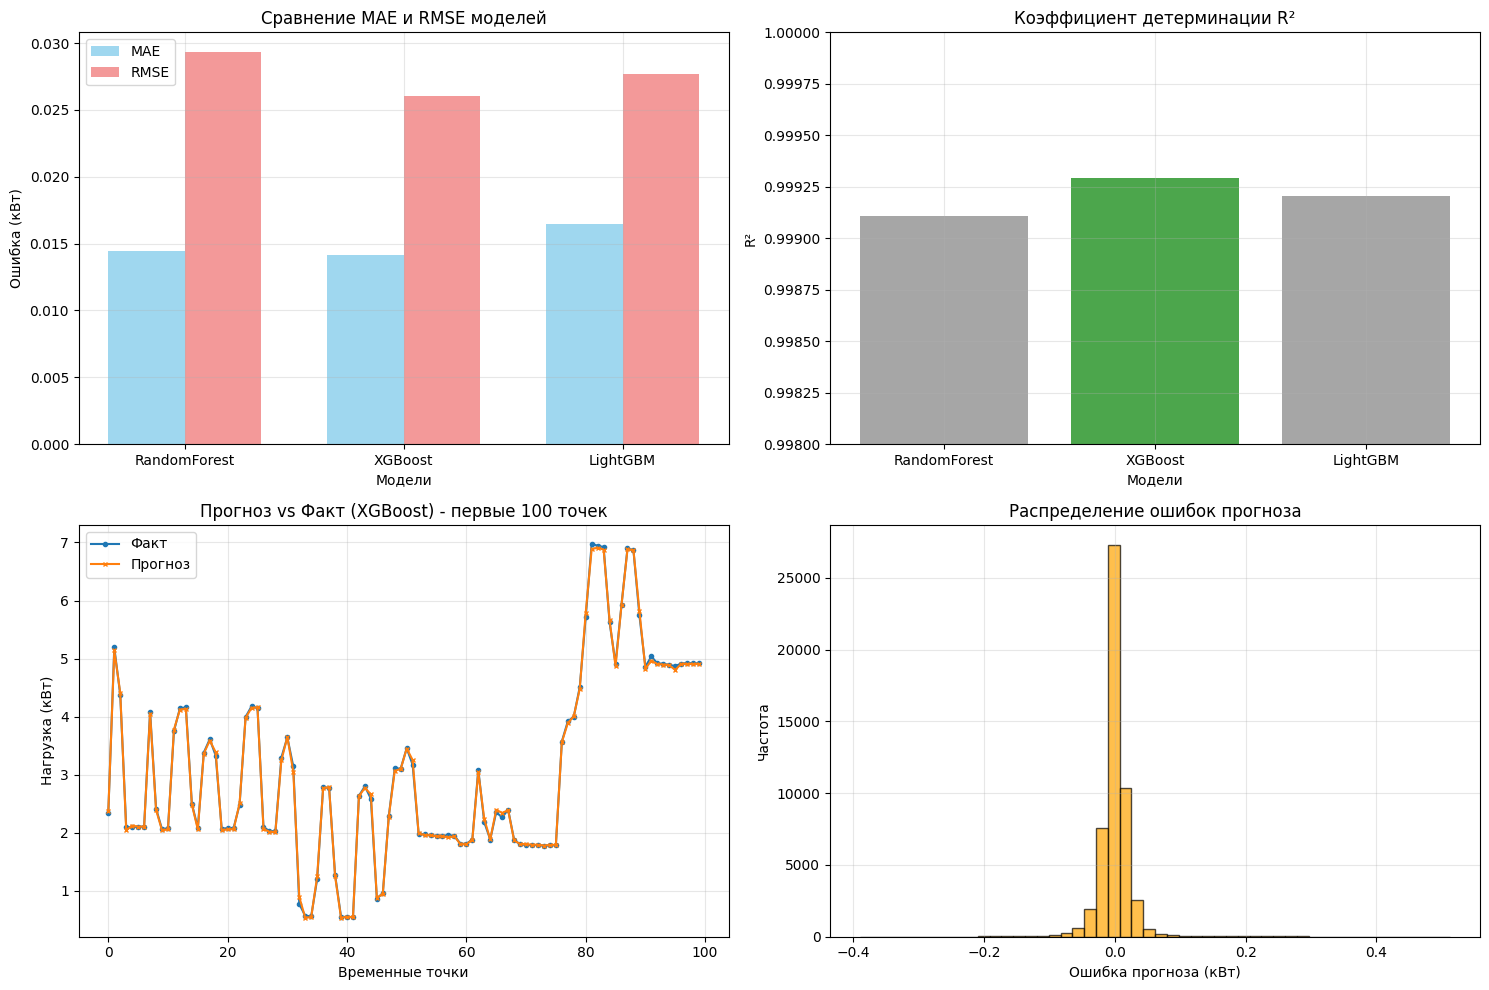


ТАБЛИЦА МЕТРИК:
Модель          MAE (кВт)    RMSE (кВт)   R²        
RandomForest    0.0144       0.0293       0.9991    
XGBoost         0.0141       0.0261       0.9993     
LightGBM        0.0165       0.0277       0.9992    

АНАЛИЗ ЛУЧШЕЙ МОДЕЛИ (XGBoost):
• Средняя ошибка: 14.1 Вт
• Точность прогноза: 99.93%
• Максимальная ошибка: 513.2 Вт


In [28]:
# ОЦЕНКА КАЧЕСТВА МОДЕЛЕЙ
print("\nОценка качества моделей на тестовой выборке:")

for name, model in models.items():
    # Прогнозы
    y_pred = model.predict(X_test)
    
    # Метрики
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'MAE': mae,
        'RMSE': rmse, 
        'R2': r2,
        'predictions': y_pred
    }
    
    print(f"\n{name}:")
    print(f"  MAE:  {mae:.4f} кВт")
    print(f"  RMSE: {rmse:.4f} кВт") 
    print(f"  R²:   {r2:.4f}")

# Сравнение моделей
print("\nСРАВНЕНИЕ МОДЕЛЕЙ:")
best_model = min(results, key=lambda x: results[x]['MAE'])
print(f"Лучшая модель по MAE: {best_model}")

# ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ
print("\nВизуализация результатов...")
import matplotlib.pyplot as plt

# ГРАФИК СРАВНЕНИЯ МЕТРИК
plt.figure(figsize=(15, 10))

# График 1: Сравнение метрик
plt.subplot(2, 2, 1)
metrics = ['MAE', 'RMSE']
models_names = list(results.keys())
mae_values = [results[model]['MAE'] for model in models_names]
rmse_values = [results[model]['RMSE'] for model in models_names]

x = np.arange(len(models_names))
width = 0.35

plt.bar(x - width/2, mae_values, width, label='MAE', alpha=0.8, color='skyblue')
plt.bar(x + width/2, rmse_values, width, label='RMSE', alpha=0.8, color='lightcoral')

plt.xlabel('Модели')
plt.ylabel('Ошибка (кВт)')
plt.title('Сравнение MAE и RMSE моделей')
plt.xticks(x, models_names)
plt.legend()
plt.grid(True, alpha=0.3)

# График 2: R² сравнение
plt.subplot(2, 2, 2)
r2_values = [results[model]['R2'] for model in models_names]
colors = ['green' if model == best_model else 'gray' for model in models_names]

plt.bar(models_names, r2_values, color=colors, alpha=0.7)
plt.xlabel('Модели')
plt.ylabel('R²')
plt.title('Коэффициент детерминации R²')
plt.ylim(0.998, 1.0)  # Увеличим масштаб для лучшей видимости
plt.grid(True, alpha=0.3)

# График 3: Прогнозы vs Факт (для лучшей модели)
plt.subplot(2, 2, 3)
best_predictions = results[best_model]['predictions']

# Берем первые 100 точек для наглядности
sample_size = min(100, len(y_test))
plt.plot(y_test.values[:sample_size], label='Факт', marker='o', markersize=3)
plt.plot(best_predictions[:sample_size], label='Прогноз', marker='x', markersize=3)
plt.xlabel('Временные точки')
plt.ylabel('Нагрузка (кВт)')
plt.title(f'Прогноз vs Факт ({best_model}) - первые 100 точек')
plt.legend()
plt.grid(True, alpha=0.3)

# График 4: Ошибки прогноза
plt.subplot(2, 2, 4)
errors = best_predictions - y_test.values
plt.hist(errors, bins=50, alpha=0.7, color='orange', edgecolor='black')
plt.xlabel('Ошибка прогноза (кВт)')
plt.ylabel('Частота')
plt.title('Распределение ошибок прогноза')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ТАБЛИЦА С МЕТРИКАМИ
print("\nТАБЛИЦА МЕТРИК:")
print("="*50)
print(f"{'Модель':<15} {'MAE (кВт)':<12} {'RMSE (кВт)':<12} {'R²':<10}")
print("="*50)
for model in models_names:
    mae = results[model]['MAE']
    rmse = results[model]['RMSE']
    r2 = results[model]['R2']
    marker = " " if model == best_model else ""
    print(f"{model:<15} {mae:<12.4f} {rmse:<12.4f} {r2:<10.4f}{marker}")
print("="*50)

# АНАЛИЗ ЛУЧШЕЙ МОДЕЛИ
print(f"\nАНАЛИЗ ЛУЧШЕЙ МОДЕЛИ ({best_model}):")
best_mae = results[best_model]['MAE']
best_rmse = results[best_model]['RMSE']
best_r2 = results[best_model]['R2']

print(f"• Средняя ошибка: {best_mae*1000:.1f} Вт")
print(f"• Точность прогноза: {best_r2*100:.2f}%")
print(f"• Максимальная ошибка: {np.max(np.abs(best_predictions - y_test.values))*1000:.1f} Вт")

In [29]:
# СОХРАНЕНИЕ МОДЕЛЕЙ И РЕЗУЛЬТАТОВ
print("Сохранение результатов...")

import os
os.makedirs('models', exist_ok=True)

# Сохраняем все модели
for name, model in models.items():
    filename = f'models/{name.lower()}_model.pkl'
    joblib.dump(model, filename)
    print(f"{name} сохранен в {filename}")

# Сохраняем лучшую модель
joblib.dump(models['XGBoost'], 'models/best_model.pkl')
print("Лучшая модель (XGBoost) сохранена")

# Сохраняем метрики в CSV
results_df = pd.DataFrame(results).T
results_df.to_csv('models/model_metrics.csv')
print("Метрики моделей сохранены")

print(f"\nВСЁ ЗАВЕРШЕНО! Лучшая модель: XGBoost (MAE: {results['XGBoost']['MAE']:.4f} кВт)")

Сохранение результатов...
RandomForest сохранен в models/randomforest_model.pkl
XGBoost сохранен в models/xgboost_model.pkl
LightGBM сохранен в models/lightgbm_model.pkl
Лучшая модель (XGBoost) сохранена
Метрики моделей сохранены

ВСЁ ЗАВЕРШЕНО! Лучшая модель: XGBoost (MAE: 0.0141 кВт)
